# Municipal Boundaries in the Americas

This example will use data from GeoBoundaries.org's data set of [Comprehensive Global Administrative Zones (CGAZ)] (https://www.geoboundaries.org/globalDownloads.html).

> CGAZ is a set of global composites for administrative boundaries. There are two important distinctions between our global product and individual country downloads. First, extensive simplification is performed to ensure that file sizes are small enough to be used in most traditional desktop software. Second, disputed areas are removed and replaced with polygons following US Department of State definitions.
> Attribution: www.geoboundaries.org

## Imports

In [ ]:
! pip install pyogrio lonboard requests pyarrow geopandas tqdm

In [5]:
import requests
import lonboard
from lonboard import SolidPolygonLayer, PathLayer, Map
import geopandas as gpd
import pyogrio
from tqdm import tqdm

- The URL for a large data file of CGAZ at ADM1 Districts level.

In [30]:

# URL of the GeoJSON file
url = "https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM1.geojson"
filepath = "geoBoundariesCGAZ_ADM1.geojson"

We'll go ahead and fetch the geojson data in that format

In [31]:
# Make a GET request to download the file
# Streaming, so we can iterate over the response and create a progress bar for this large file
response = requests.get(url, stream=True)

# Sizes in bytes.
total_size = int(response.headers.get("content-length", 0))
block_size = 1024

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filepath, "wb") as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

if total_size != 0 and progress_bar.n != total_size:
    raise RuntimeError("Could not download file")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 361M/361M [05:33<00:00, 1.08MB/s]


## Visualize North, Central, and South America
In this demonstration, we're going to use a large bounding box around North, Central, and South America for our visualization

In [32]:
# Use pyogrio engine for an optimization of the time it takes to read this file
# We will also enable use_arrow, for speed

# this bounding box will visualize the Western Hemisphere - North, Central, and South America.
nh_bbox = (-175.910339,-59.265881,-27.199402,74.449358)

gdf = gpd.read_file(f"./{filepath}",bbox=nh_bbox,engine='pyogrio',use_arrow=True)

# Keep columns necessary for our visualization
cols = ['shapeName','shapeID','geometry']

gdf = gdf[cols]

We can take a quick look at this data before visualizing.

In [33]:
gdf.head(10)

,shapeName,shapeID,geometry
0,Mississippi,66186276B69138566591314,"MULTIPOLYGON (((-88.77009 30.24290, -88.75279 ..."
1,North Carolina,66186276B6801956407400,"MULTIPOLYGON (((-75.74650 35.19336, -75.74553 ..."
2,Oklahoma,66186276B83300161667341,"POLYGON ((-103.00221 37.00011, -103.00253 36.6..."
3,Virginia,66186276B53580985925186,"MULTIPOLYGON (((-75.64425 37.97135, -75.64337 ..."
4,West Virginia,66186276B64762166704956,"POLYGON ((-77.71952 39.32132, -77.75579 39.333..."
5,Louisiana,66186276B41335105066757,"MULTIPOLYGON (((-88.87048 30.04922, -88.86152 ..."
6,Michigan,66186276B37442548568489,"MULTIPOLYGON (((-83.77402 46.05147, -83.75999 ..."
7,Massachusetts,66186276B15934532614691,"MULTIPOLYGON (((-70.20054 41.27857, -70.20119 ..."
8,Idaho,66186276B48953429733047,"POLYGON ((-116.91600 45.99542, -116.89287 45.9..."
9,Florida,66186276B65591139260314,"MULTIPOLYGON (((-80.22604 25.40281, -80.22622 ..."


## Preparing the data for our Map

In this demonstration, we want to end up with a pickable map of municipal boundaries in the Americas with nice looking borders around municipal areas so that we can see the boundaries not being activately picked.
To accomplish that, we'll perform the following to create a lonboard `PathLayer` along with our `SolidPolygonLayer`

Our dataset contains `Polygon` and `MultiPolygon` geometries

In [67]:
mississippi = gdf[gdf['shapeName'] == 'Mississippi']
mississippi

,shapeName,shapeID,geometry
0,Mississippi,66186276B69138566591314,"MULTIPOLYGON (((-88.77009 30.24290, -88.75279 ..."


For MultiPolygons, we can get the `unary_union` of the polygon to obtain a `boundary` of the `MultiPolygon`

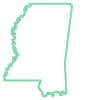

In [68]:
unary_mississippi = mississippi.unary_union
unary_mississippi.boundary

For Polygons, we can get the boundary of the polygon to obtain an "outline" of the Polygon

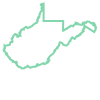

In [70]:
gdf.iloc[4]['geometry'].boundary

## Creating a GeoDataFrame of Boundaries

Now that we have a way to get the boundary of Polygons and MultiPolygons, let's use those boundaries to create a GeoDataFrame of the geometry boundaries.

In [37]:
# Step 1: Calculate 'boundary' for each geometry
# Instead of adding it to the original gdf, directly create a new GeoSeries
boundaries = gdf['geometry'].apply(lambda geom: geom.boundary)

# Step 2: Create a new GeoDataFrame from the boundaries GeoSeries, 
# explicitly setting it as the 'geometry' column
boundary_gdf = gpd.GeoDataFrame(geometry=boundaries)

Let's take a look at the Boundaries GeoDataFrame

In [38]:
boundary_gdf.head()

,geometry
0,"MULTILINESTRING ((-88.77009 30.24290, -88.7527..."
1,"MULTILINESTRING ((-75.74650 35.19336, -75.7455..."
2,"LINESTRING (-103.00221 37.00011, -103.00253 36..."
3,"MULTILINESTRING ((-75.64425 37.97135, -75.6433..."
4,"LINESTRING (-77.71952 39.32132, -77.75579 39.3..."


## Combining SolidPolygonLayer and PathLayer 
Now let's create a lonboard `PathLayer` from the `boundary` column of `LineString` and `MultiLineString` geometries

In [ ]:
# set up our fill and line colors
fill_rgb = [204, 251, 254] # light blue
border_rgb = [37, 36, 34] # dark border color

In [61]:
borders_layer = PathLayer.from_geopandas(
    boundary_gdf,
    get_color=border_rgb,
    get_width=2,
    width_min_pixels=1
)

In [62]:
polygon_layer = SolidPolygonLayer.from_geopandas(
    gdf,
    auto_highlight=True,
    extruded=True,
    filled=False,
    get_fill_color=fill_rgb,
    get_line_color=border_rgb,
    wireframe=True,
)

In [63]:
map_ = Map(layers=[polygon_layer,borders_layer])

In [64]:
# visualize the interactive map with lonboard
map_

Map(layers=[SolidPolygonLayer(auto_highlight=True, extruded=True, get_fill_color=[204, 251, 254], get_line_col…